In [49]:
import pandas as pd

# Demand prediction problem
class DemandPrediction:
    N_DEMAND_INDICATORS = 13;
    # Parameters consist of a bias (intercept) for the sum and one weight for
    # each demand indicator.
    N_PARAMETERS = N_DEMAND_INDICATORS + 1;

    # Construct a Demand prediction problem instance.
    # The parameter "dataset_name" specifies which dataset to use. Valid values
    # are "train" or "test".
    def __init__(self,dataset_name):
      #Load the specified dataset
      if(dataset_name == "train"):
        self.__X, self.__y = DemandPrediction.__load_dataset("data/train.csv");
      elif(dataset_name == "test"):
        self.__X, self.__y = DemandPrediction.__load_dataset("data/test.csv");
      else:
        raise Exception("Only permitted arguments for " +
          "DemandPrediction::__init__ are train and test.")

    # Rectangular bounds on the search space.
    # Returns a 2D array b such that b[i][0] is the minimum permissible value
    # of the ith solution component and b[i][1] is the maximum.
    def bounds():
        return [[-100,100] for i in range(DemandPrediction.N_PARAMETERS)]

    # Check whether the function parameters (weights) lie within the
    # problem's feasible region.
    # There should be the correct number of weights for the predictor function.
    # Each weight should lie within the range specified by the bounds.
    def is_valid(self, parameters):
        if(len(parameters) != DemandPrediction.N_PARAMETERS):
          return False
        #All weights lie within the bounds.
        b = DemandPrediction.bounds();
        for i in range(len(b)):
          if(parameters[i] < b[i][0] or parameters[i] > b[i][1] ):
            return False
        return True;

    # Evaluate a set of parameters on the dataset used by the class instance
    # (train/test).
    # @param parameters An containing the bias and weights to be used to
    #   predict demand.
    # @return The mean absolute error of the predictions on the selected
    # dataset.
    def evaluate(self, parameters):
        abs_error = 0.0;
        for (x, y) in zip(self.__X,self.__y):
            #print(list(self.__X.values))
            #print(x)
            #print(y)
            #print('--')
            y_pred = DemandPrediction.__predict(x,parameters);
            abs_error += abs(y-y_pred);
        abs_error /= len(self.__X);
        return abs_error;

    def __load_dataset(filename):
        if "train.csv" in filename:
            df = pd.read_csv(filename)
            df = df.iloc[:, 1:]
        else:
            df = pd.read_csv(filename,header=None)
            # print(df.head())
        y = df.iloc[:,0].values
        X = df.iloc[:,1:].values
        return X, y

    # Predicts demand based on a weighted sum of demand indicators. You may
    # replace this with something more complex, but will likely have to change
    # the form of the parameters array as well.
    def __predict(demand_indicators, parameters):
        prediction = parameters[0];

        for i in range(1, len(demand_indicators)):
            prediction += demand_indicators[i] * parameters[i];

        return prediction;

In [35]:
import numpy as np
#from DemandPrediction_v2 import DemandPrediction

def cost_function(x):
    training_problem = DemandPrediction("train")
    error = training_problem.evaluate(x)
    return error

def initialize_population(pop_size, bounds):
    dimensions = len(bounds)
    return np.array([np.random.uniform(bounds[:, 0], bounds[:, 1], dimensions) for _ in range(pop_size)])

def selection(population, fitness, num_parents):
    parents = np.empty((num_parents, population.shape[1]))
    for i in range(num_parents):
        min_index = np.argmin(fitness)
        parents[i] = population[min_index]
        fitness[min_index] = float('inf')
    return parents

def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size)
    crossover_point = np.uint32(offspring_size[1] / 2)
    for k in range(offspring_size[0]):
        parent1_index = k % parents.shape[0]
        parent2_index = (k + 1) % parents.shape[0]
        offspring[k, 0:crossover_point] = parents[parent1_index, 0:crossover_point]
        offspring[k, crossover_point:] = parents[parent2_index, crossover_point:]
    return offspring

def mutation(offspring, bounds, mutation_rate):
    for i in range(offspring.shape[0]):
        for j in range(offspring.shape[1]):
            if np.random.rand() < mutation_rate:
                random_value = np.random.uniform(bounds[j, 0], bounds[j, 1])
                offspring[i, j] = random_value
    return offspring



In [36]:
def ga(cost_function, bounds, pop_size, num_generations, mutation_rate, verbose = True):
    # GA parameters
    # pop_size = 100
    # num_generations = 1000
    num_parents = int(pop_size / 2)
    # mutation_rate = 0.5

    # bounds = np.array(DemandPrediction.bounds())

    # Initialize population
    population = initialize_population(pop_size, bounds)

    error_list = []
    # Run GA optimization
    for generation in range(num_generations):
        fitness = np.array([cost_function(individual) for individual in population])
        parents = selection(population, fitness.copy(), num_parents)
        offspring = crossover(parents, offspring_size=(pop_size - num_parents, bounds.shape[0]))
        offspring = mutation(offspring, bounds, mutation_rate)
        population[0:parents.shape[0]] = parents
        population[parents.shape[0]:] = offspring

        # Optional: print progress
        best_individual = population[np.argmin(fitness)]
        best_fitness = np.min(fitness)
        if verbose:
            print("Generation {}/{}, Best Fitness: {}".format(generation + 1, num_generations, best_fitness))
        error_list.append(best_fitness)

    # Get the best solution
    best_solution = population[np.argmin(fitness)]
    best_cost = np.min(fitness)

    print("Best training error after {} generations: {}".format(num_generations, best_cost))

    # Check the MAE of the best solution on the test problem
    test_problem = DemandPrediction("test")
    test_error = test_problem.evaluate(best_solution)
    print("Test error of best solution found while training: {}".format(test_error))
    return best_solution, best_cost, error_list


In [50]:
if __name__ == "__main__":
    pop_size = 150
    num_generations = 1500
    mutation_rate = 0.2

    bounds = np.array(DemandPrediction.bounds())
    best_solution, best_cost, error_list = ga(cost_function, bounds, pop_size, num_generations, mutation_rate)

Generation 1/1500, Best Fitness: 1085.8886311072515
Generation 2/1500, Best Fitness: 1078.965601777353
Generation 3/1500, Best Fitness: 1040.6262960314573
Generation 4/1500, Best Fitness: 601.4014297453742
Generation 5/1500, Best Fitness: 601.4014297453742
Generation 6/1500, Best Fitness: 601.4014297453742
Generation 7/1500, Best Fitness: 601.4014297453742
Generation 8/1500, Best Fitness: 495.043832251303
Generation 9/1500, Best Fitness: 495.043832251303
Generation 10/1500, Best Fitness: 480.82788540700466
Generation 11/1500, Best Fitness: 480.82788540700466
Generation 12/1500, Best Fitness: 480.82788540700466
Generation 13/1500, Best Fitness: 305.7882865429823
Generation 14/1500, Best Fitness: 305.7882865429823
Generation 15/1500, Best Fitness: 284.31090278136213
Generation 16/1500, Best Fitness: 284.31090278136213
Generation 17/1500, Best Fitness: 284.31090278136213
Generation 18/1500, Best Fitness: 255.8126679158306
Generation 19/1500, Best Fitness: 245.3049384378864
Generation 20/1

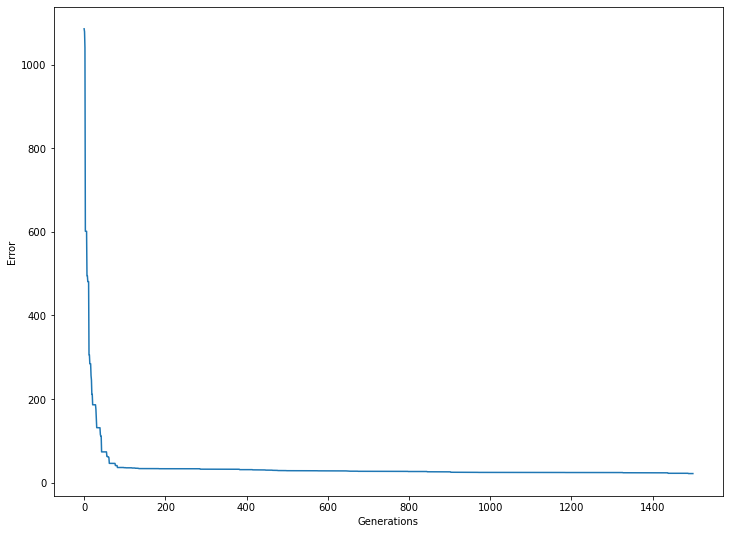

In [51]:
import matplotlib.pyplot as plt

# The variation of the cost over the generations
plt.figure(figsize = (12, 9))
plt.plot(error_list)
plt.xlabel('Generations')
plt.ylabel('Error')
plt.show()

In [52]:
best_solution

array([ 13.10547795,   1.89856906,   0.64247938,   5.87429559,
        -0.13991033,  -0.31668846,  -3.34781053,  56.53977207,
        34.61663496,  54.05217851,  23.03558044, -44.79213917,
       -76.58908331, -62.10248641])